In [50]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [51]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [52]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [53]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [54]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          651 non-null    object 
 1   Daily Confirmed                               651 non-null    int64  
 2   False Positives Found                         542 non-null    float64
 3   Cumulative Confirmed                          651 non-null    int64  
 4   Daily Discharged                              651 non-null    int64  
 5   Passed but not due to COVID                   651 non-null    int64  
 6   Cumulative Discharged                         651 non-null    int64  
 7   Discharged to Isolation                       651 non-null    int64  
 8   Still Hospitalised                            651 non-null    int64  
 9   Daily Deaths                                  651 non-null    int

In [56]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [57]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [58]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [59]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [60]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [61]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [62]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               651 non-null    int64  
 1   False Positives Found                         651 non-null    float64
 2   Cumulative Confirmed                          651 non-null    int64  
 3   Daily Discharged                              651 non-null    int64  
 4   Passed but not due to COVID                   651 non-null    int64  
 5   Cumulative Discharged                         651 non-null    int64  
 6   Discharged to Isolation                       651 non-null    int64  
 7   Still Hospitalised                            651 non-null    int64  
 8   Daily Deaths                                  651 non-null    int64  
 9   Cumulative Deaths                             651 non-null    int

<AxesSubplot:>

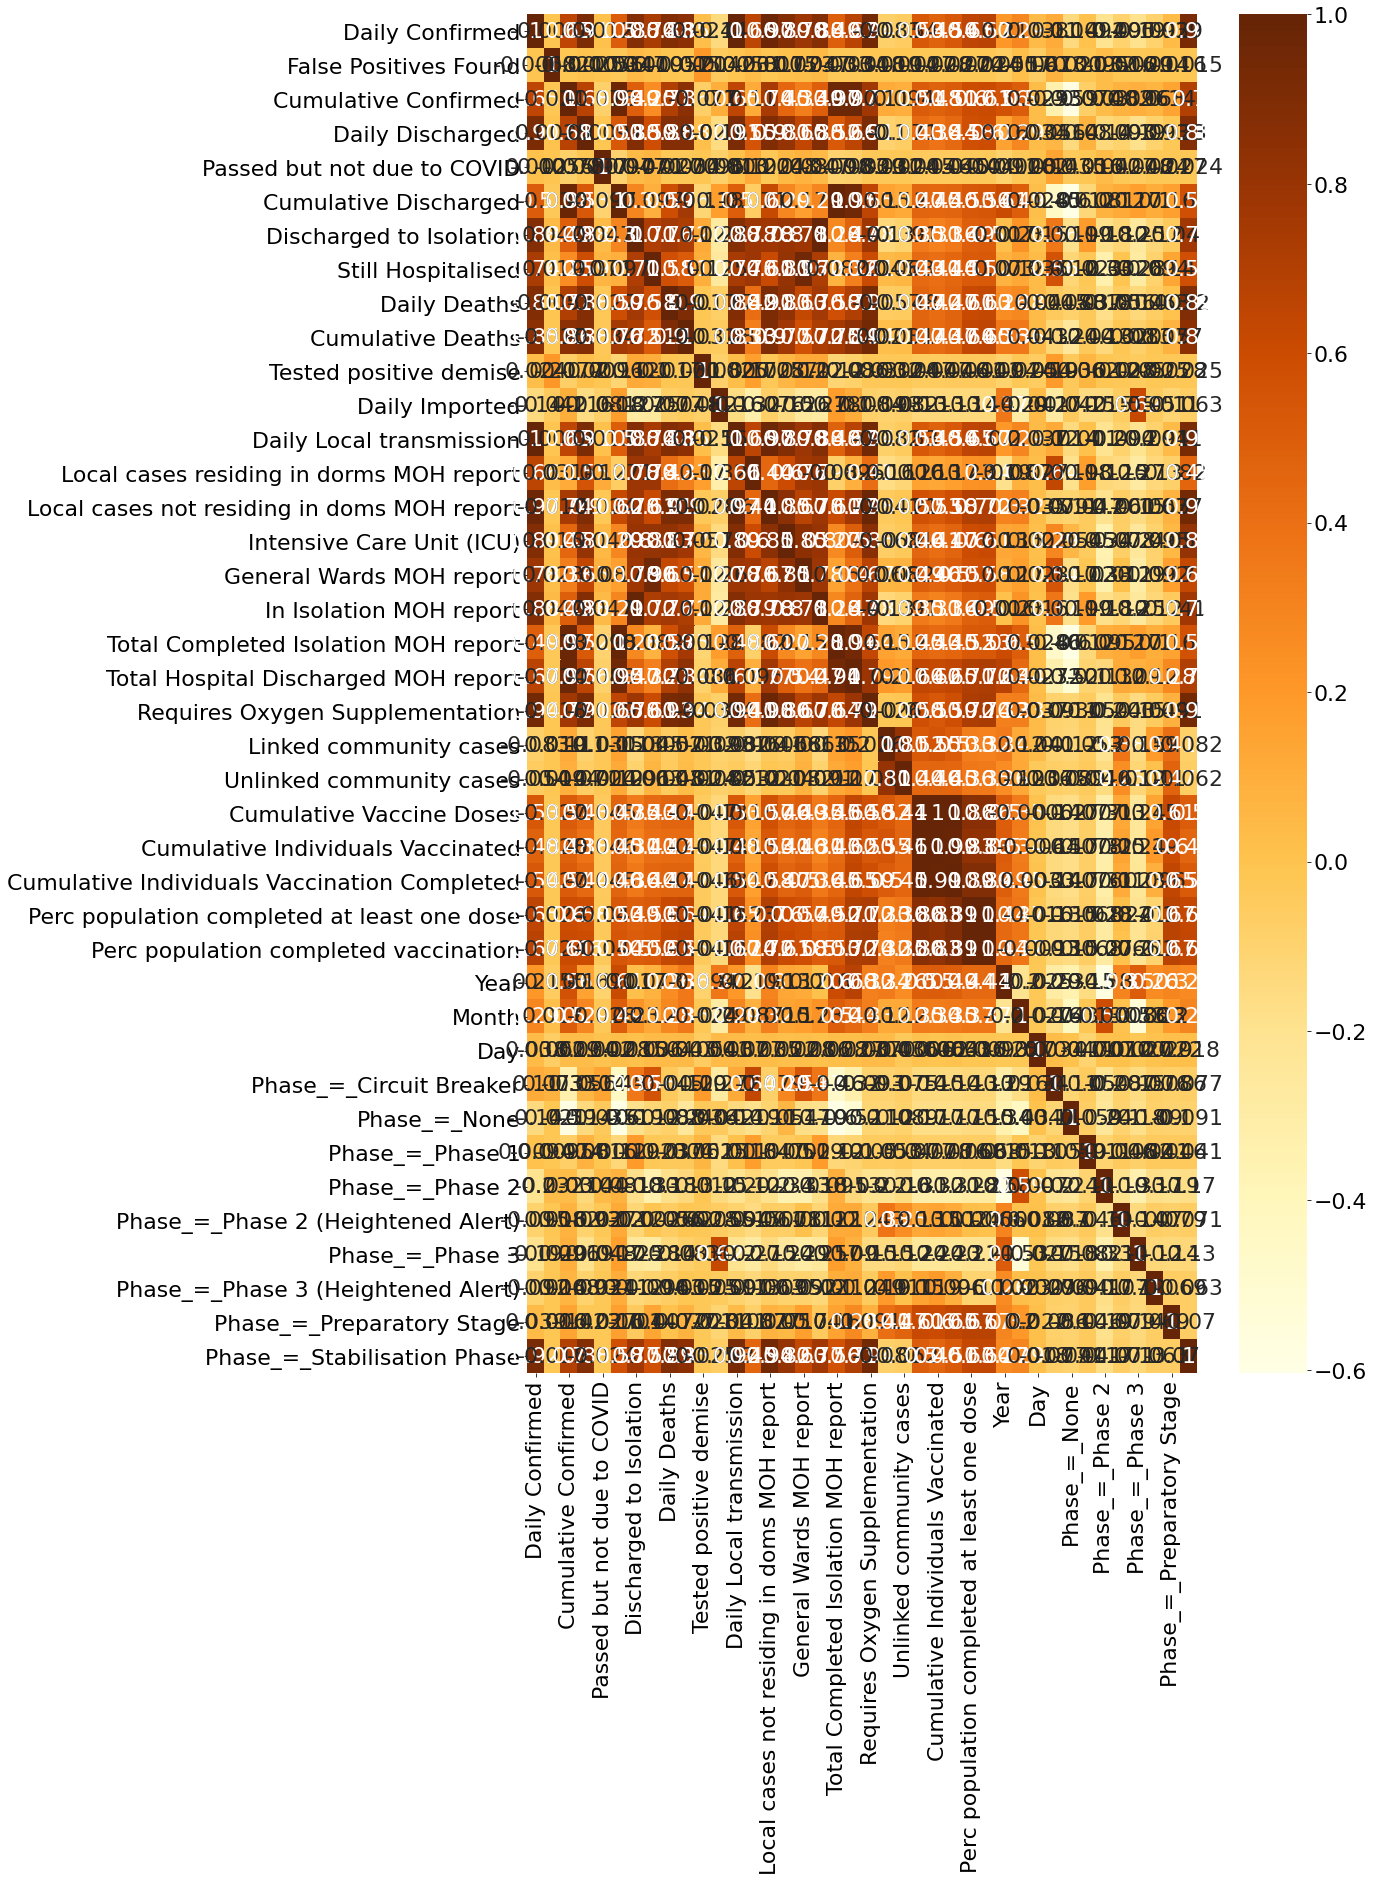

In [63]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [64]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Daily Imported"].sort_values(ascending=False)

Daily Imported                                  1.000000
Phase_=_Phase 3                                 0.623945
Year                                            0.365998
Total Completed Isolation MOH report            0.180587
Cumulative Discharged                           0.176231
Total Hospital Discharged MOH report            0.104910
Cumulative Confirmed                            0.101019
Day                                             0.041164
Phase_=_None                                   -0.041612
False Positives Found                          -0.042002
Cumulative Deaths                              -0.047602
Phase_=_Phase 3 (Heightened Alert)             -0.051439
Phase_=_Phase 2 (Heightened Alert)             -0.055121
Phase_=_Stabilisation Phase                    -0.062971
Local cases not residing in doms MOH report    -0.075698
Daily Deaths                                   -0.076695
Passed but not due to COVID                    -0.080584
Unlinked community cases       

In [65]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [66]:
# pca.components_[0]

In [67]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [68]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Viewing Chart Pattern

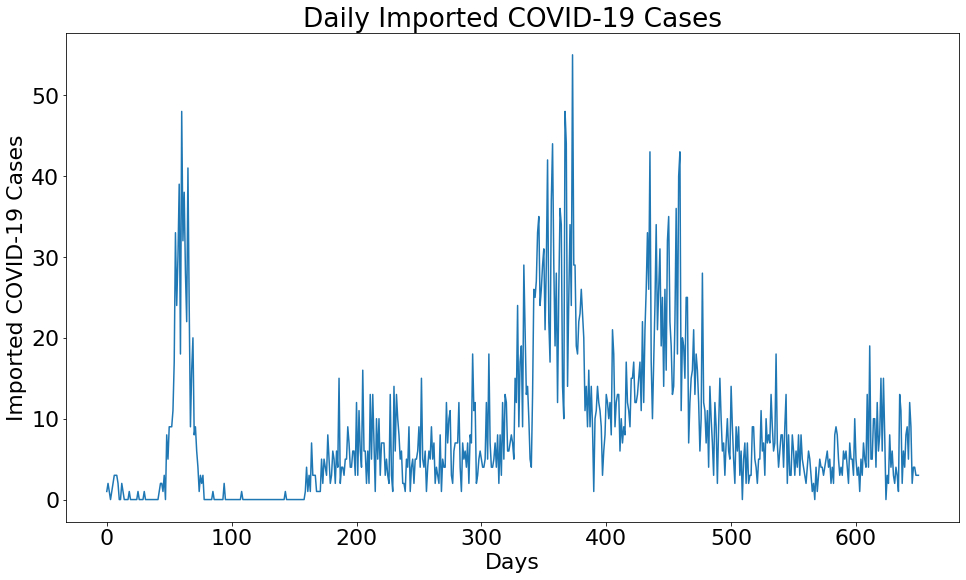

In [69]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Daily Imported"].plot()
plt.title('Daily Imported COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('Imported COVID-19 Cases')
plt.show()
# fig.savefig('Daily_Imported_COVID-19_Cases.png')

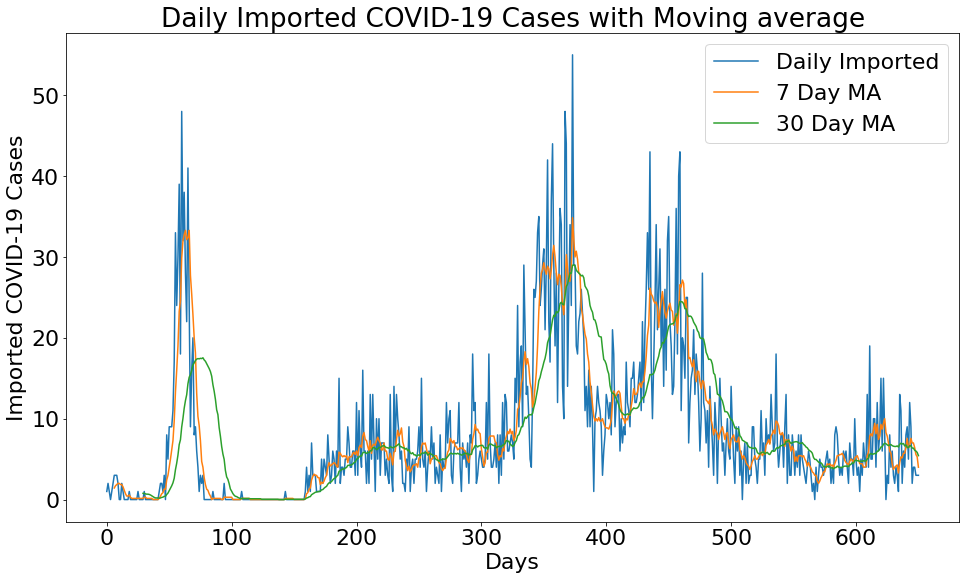

In [70]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Daily Imported"], label="Daily Imported")
ax.plot(sg_data_filtered["Daily Imported"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Daily Imported"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Daily Imported COVID-19 Cases with Moving average')
plt.xlabel('Days')
plt.ylabel('Imported COVID-19 Cases')
plt.show()
# fig.savefig('Daily_Imported_COVID-19_Cases_with_Moving_average.png')

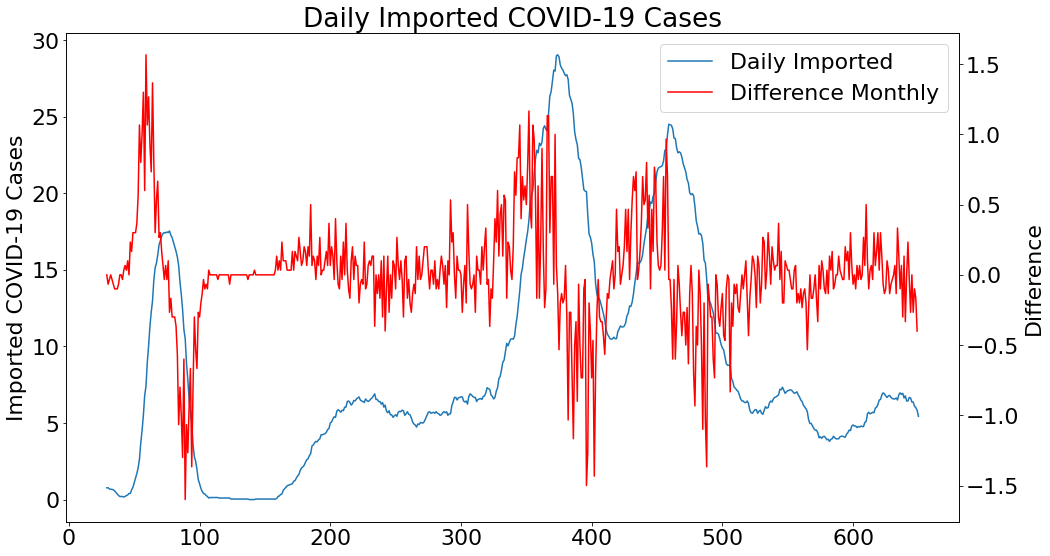

In [71]:
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Daily Imported"].rolling(window=30).mean(), label="Daily Imported")
ax.set_ylabel("Imported COVID-19 Cases")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Daily Imported"].rolling(window=30).mean()), label="Difference Monthly",color='red')
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1+ln2)])
plt.title('Daily Imported COVID-19 Cases')
plt.xlabel('Days')
plt.show()
# fig.savefig('Daily_Imported_COVID-19_Cases_diff.png')

# Train Test Split & K Fold Cross Validation

In [72]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Daily Imported", axis=1)
y = sg_data_filtered["Daily Imported"]

In [73]:
# split using 20% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [74]:
# K Fold Stratified with 5 folds

# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [75]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [76]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 2.6838754987332517e-11
MSE: 3.488120766147329e-21
RMSE: 5.906031464653172e-11
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0
Cross Validation Score: 1.0


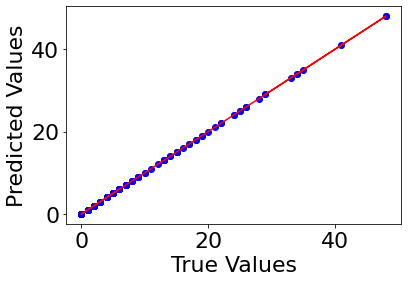

In [77]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

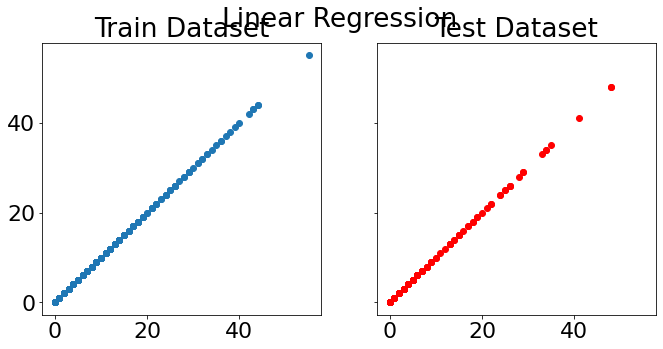

In [78]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [79]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,1.000000e+00
5,Cumulative Discharged,5.924888e-11
6,Discharged to Isolation,5.868435e-11
7,Still Hospitalised,5.868238e-11
9,Cumulative Deaths,5.867219e-11
4,Passed but not due to COVID,2.846169e-11
1,False Positives Found,1.439458e-11
28,Month,1.652222e-12
14,Intensive Care Unit (ICU),1.287139e-12
12,Local cases residing in dorms MOH report,9.532960e-13


# Ridge Regression

In [80]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.00827e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [81]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.000922998416761472
MSE: 2.7555092410599264e-06
RMSE: 0.0016599726627447593
R-squared score for train: 0.9999999777226634
Adjusted R-squared score for train: 0.9999999763007057
R-squared score for test: 0.9999999751583651
Adjusted R-squared score for test: 0.9999999735727289
Cross Validation Score: 1.0


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.00827e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.47126e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.6846e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.41581e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.01288e-17): result may not be accurate.

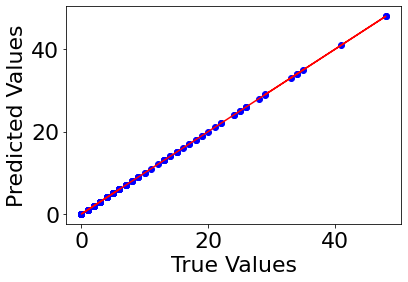

In [82]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

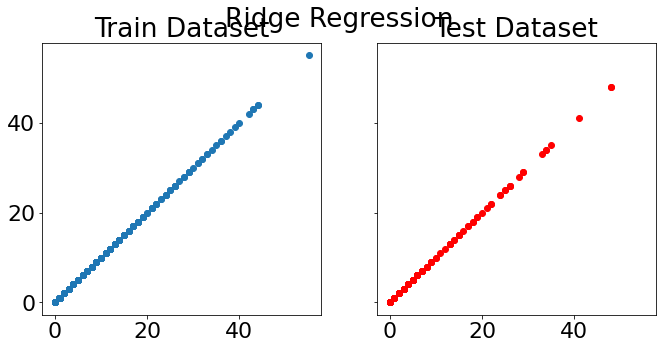

In [83]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [84]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
0,Daily Confirmed,9.998411e-01
35,Phase_=_Phase 3,1.169504e-03
30,Phase_=_Circuit Breaker,7.161044e-04
32,Phase_=_Phase 1,1.524455e-04
26,Perc population completed vaccination,1.298215e-04
33,Phase_=_Phase 2,1.192935e-04
25,Perc population completed at least one dose,1.164793e-04
27,Year,1.104991e-04
2,Cumulative Confirmed,7.388540e-05
8,Daily Deaths,2.005247e-05


# Important Features & Future Prediction

In [85]:
important_X = X[["Daily Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Daily Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Daily Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [86]:
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
ridge_pred = impt_ridge.predict(important_X_test)

In [87]:
train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 5.067127333252527
MSE: 70.90383669450975
RMSE: 8.420441597357573
R-squared score for train: 0.48035372457196446
Adjusted R-squared score for train: 0.46974869854282086
R-squared score for test: 0.3607834091489681
Adjusted R-squared score for test: 0.3477381726009878
Cross Validation Score: 0.4392


# XGBoost

In [88]:
xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=5)
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.7,
 'min_child_weight': 2,
 'max_depth': 10,
 'colsample_bytree': 0.7}

In [89]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=8, colsample_bytree=0.7, min_child_weight=2)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 2.411819840312175
MSE: 14.414059494839462
RMSE: 3.796585241350372
R-squared score for train: 0.9900123698805023
Adjusted R-squared score for train: 0.9898085406943902
R-squared score for test: 0.870053492164146
Adjusted R-squared score for test: 0.8674015226164755
Cross Validation Score: 0.8639


# Prediction with XGBoost

In [98]:
future_prediction = pd.DataFrame(data={
    "Daily Confirmed":[1000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Stabilisation Phase":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[1],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([5.228503], dtype=float32)

In [91]:
xgb_fut_pred
# imported case of 10 on 14 Dec 2021

array([3.3558443], dtype=float32)